# Configuration

In [1]:
# Import libraries
import pandas            as pd
import matplotlib.pyplot as plt
import os                as os
import seaborn           as sns

from amberdata_derivatives import AmberdataDerivatives
from matplotlib.ticker     import MaxNLocator

import warnings
warnings.filterwarnings("ignore")

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Retrieve API key
API_KEY = os.getenv("API_KEY")

# Amberdata SDK

In [2]:
amberdata_client = AmberdataDerivatives(api_key=API_KEY)

amberdata_client.get

# Open Interest for BTC option contracts

Text(0.5, 0, 'Option Contracts (Thousands)')

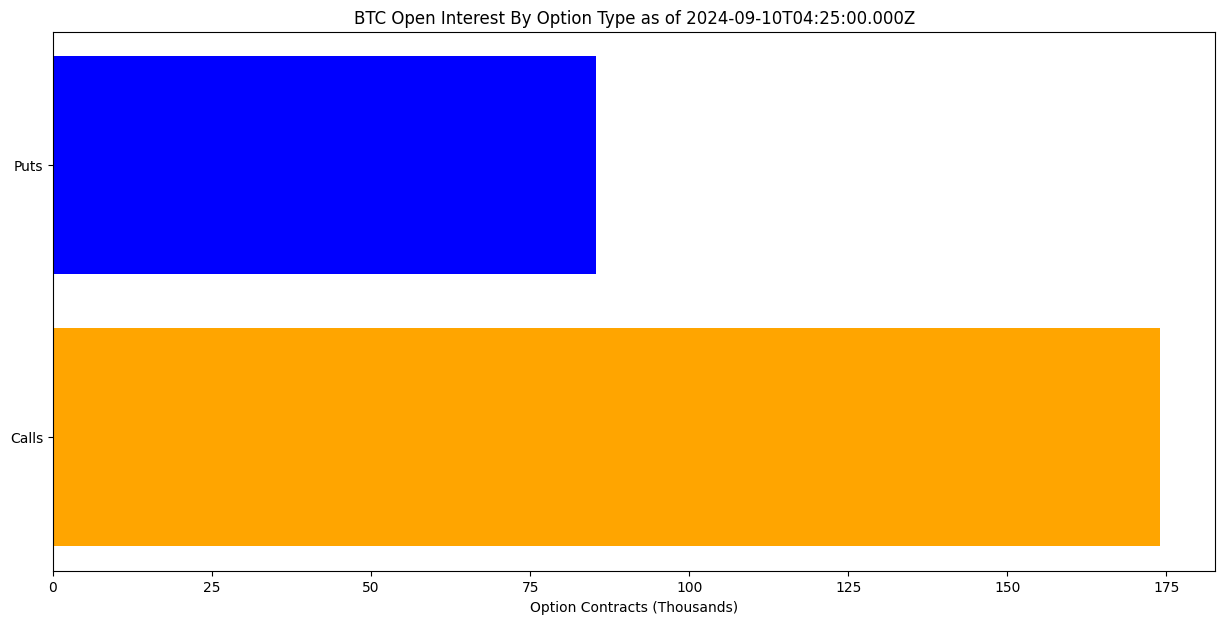

In [3]:
data = pd.DataFrame(amberdata_client.get_volatility_level_1_quotes(exchange='deribit', currency='btc')['payload']['data'])
oi   = data.groupby("putCall").sum()

plt.figure(figsize=(15, 7))
plt.barh(['Calls'], oi['openInterest']['C']/1_000, color='orange')
plt.barh(['Puts'],  oi['openInterest']['P']/1_000, color='blue')
plt.title("BTC Open Interest By Option Type as of " + str(data.timestamp[0]))
plt.xlabel("Option Contracts (Thousands)")

# Distribution of BTC option Open Interest across all strikes

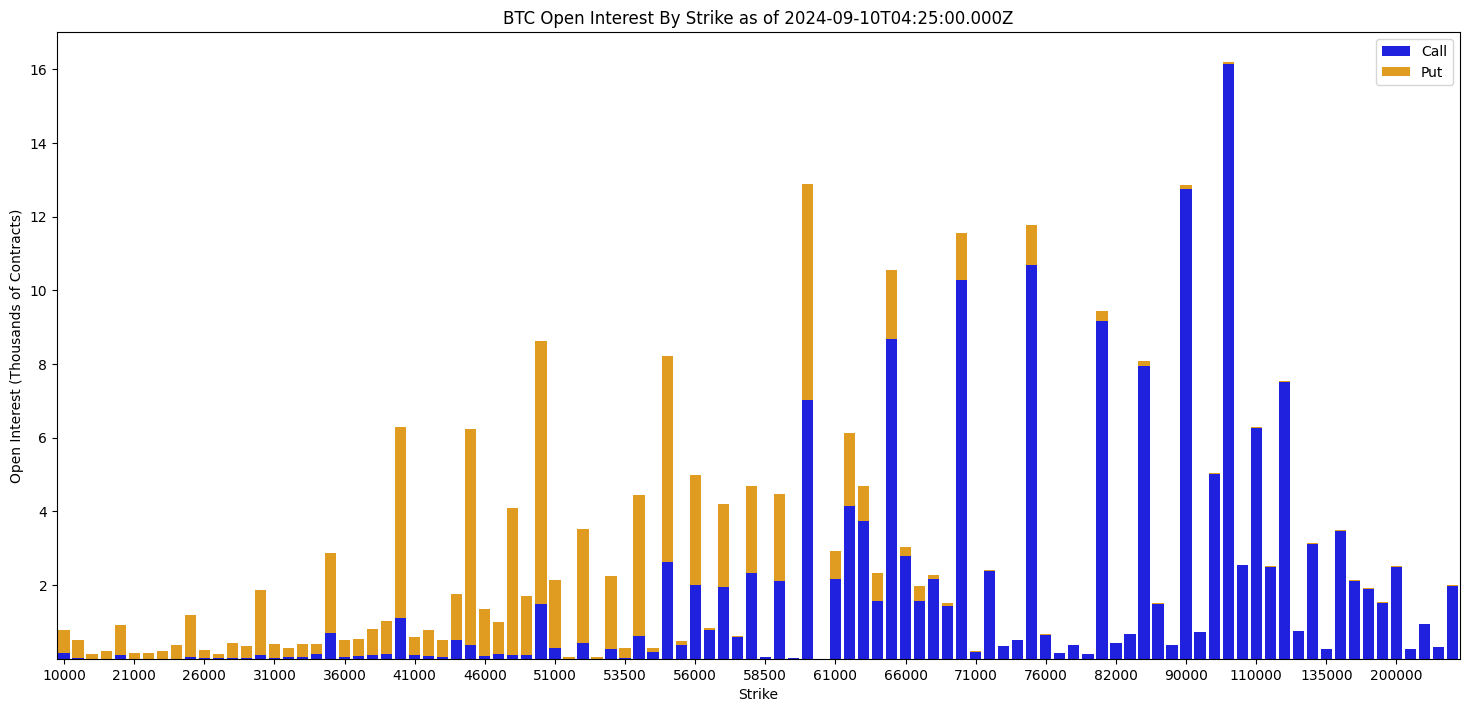

In [4]:
data = pd.DataFrame(amberdata_client.get_volatility_level_1_quotes(exchange='deribit', currency='btc')['payload']['data'])

calls = data[data.putCall=='C']
puts  = data[data.putCall=='P']

call_strike_oi = calls.groupby("strike").sum()[['openInterest']].reset_index()
put_strike_oi  =  puts.groupby("strike").sum()[['openInterest']].reset_index()

plt.figure(figsize=(15, 7))
sns.barplot(x=call_strike_oi.strike, y=call_strike_oi.openInterest/1000, color='blue',   label='Call')
sns.barplot(x=put_strike_oi.strike,  y= put_strike_oi.openInterest/1000, color='orange', label='Put', bottom=call_strike_oi.openInterest/1000)

plt.tight_layout()
plt.gca().xaxis.set_major_locator(MaxNLocator(20))
plt.legend()
plt.title("BTC Open Interest By Strike as of " + str(data.timestamp[0]))
plt.ylabel("Open Interest (Thousands of Contracts)")
plt.xlabel("Strike");

# Distribution of BTC option Open Interest across all maturities

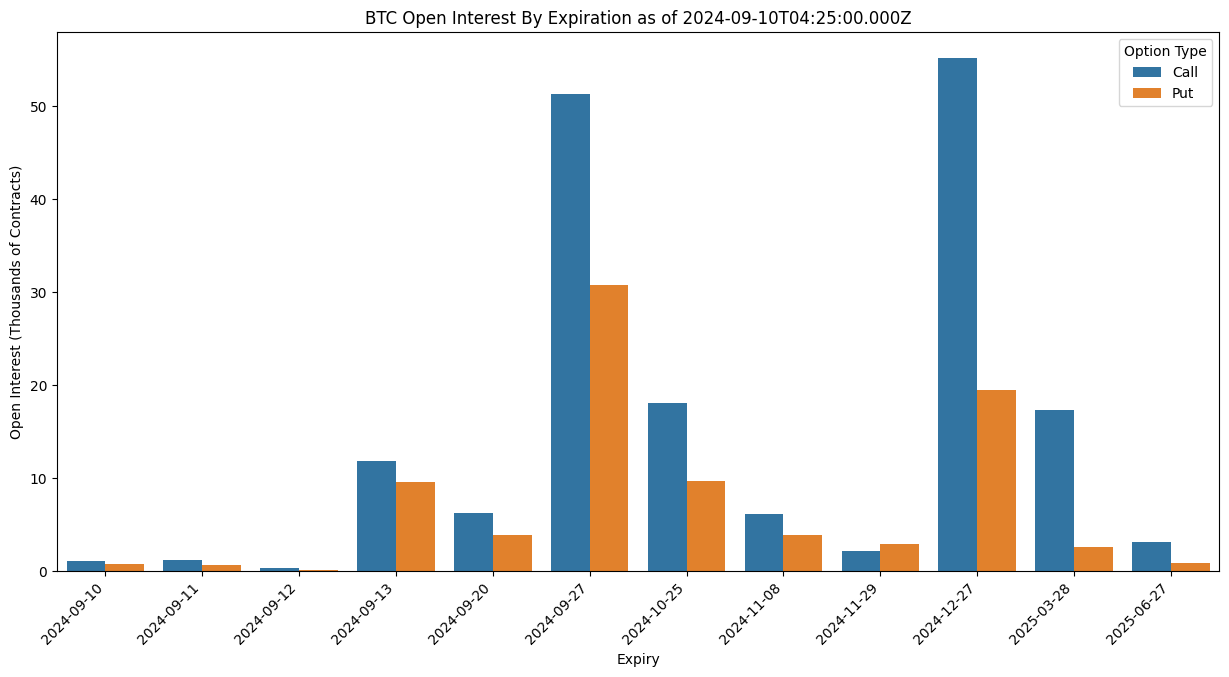

In [5]:
data = pd.DataFrame(amberdata_client.get_volatility_level_1_quotes(exchange='deribit', currency='btc')['payload']['data'])

calls = data[data.putCall=='C']
puts  = data[data.putCall=='P']

calls['expirationTimestamp'] = pd.to_datetime(calls.expirationTimestamp).dt.date
puts ['expirationTimestamp'] = pd.to_datetime( puts.expirationTimestamp).dt.date

c = calls.groupby("expirationTimestamp").sum().reset_index()
p = puts .groupby("expirationTimestamp").sum().reset_index()

c['openInterest'] /= 1000
p['openInterest'] /= 1000

c['op_type'] = 'Call'
p['op_type'] = 'Put'
t = pd.concat([c, p]).reset_index(drop=True)

# Create the bar plot
plt.figure(figsize=(15, 7))
sns.barplot(data=t, x='expirationTimestamp', y='openInterest', hue='op_type')
plt.xticks(rotation=45, ha='right');
plt.title("BTC Open Interest By Expiration as of " + str(data.timestamp[0]))
plt.ylabel("Open Interest (Thousands of Contracts)")
plt.xlabel("Expiry")
plt.legend(title='Option Type')

# 24 hours change in Open Interest

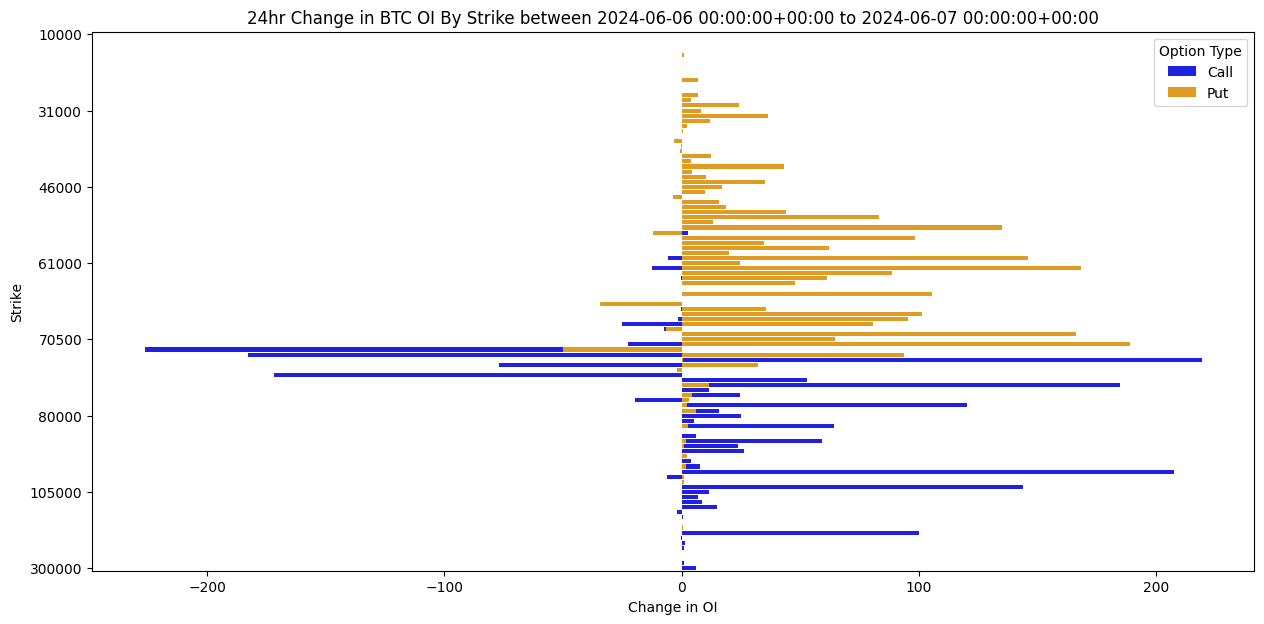

In [6]:
data = pd.DataFrame(amberdata_client.get_volatility_level_1_quotes(exchange='deribit', currency='btc', startDate='2024-06-05', endDate='2024-06-08', timeInterval='day')['payload']['data'])                                                     
data['timestamp'] = pd.to_datetime(data.timestamp)

yday = data[data.timestamp == '2024-06-06 00:00:00+00:00']
tday = data[data.timestamp == '2024-06-07 00:00:00+00:00']

tday_c = tday[tday.putCall=='C'].groupby("strike")[['openInterest']].sum()
tday_p = tday[tday.putCall=='P'].groupby("strike")[['openInterest']].sum()

yday_c = yday[yday.putCall=='C'].groupby("strike")[['openInterest']].sum()
yday_p = yday[yday.putCall=='P'].groupby("strike")[['openInterest']].sum()

call = pd.concat([tday_c, yday_c], axis=1)
call.columns = ['today', 'yesterday']
call['diffs'] = call.today - call.yesterday

put = pd.concat([tday_p, yday_p], axis=1)
put.columns = ['today', 'yesterday']
put['diffs'] = put.today - put.yesterday

call = call.reset_index()
put  = put.reset_index()

plt.figure(figsize=(15, 7))
sns.barplot(x=call.diffs, y=call.strike,  orient = 'h', color='blue', label='Call')
sns.barplot(x=put.diffs, y=put.strike,  orient = 'h', color='orange', label='Put')
plt.gca().yaxis.set_major_locator(MaxNLocator(10))

plt.title("24hr Change in BTC OI By Strike between " + str(yday.timestamp.iloc[0]) + " to " + str(tday.timestamp.iloc[0]))
plt.ylabel("Strike")
plt.xlabel("Change in OI")
plt.legend(title='Option Type')

# 24 hours change in Open Interest based on maturity

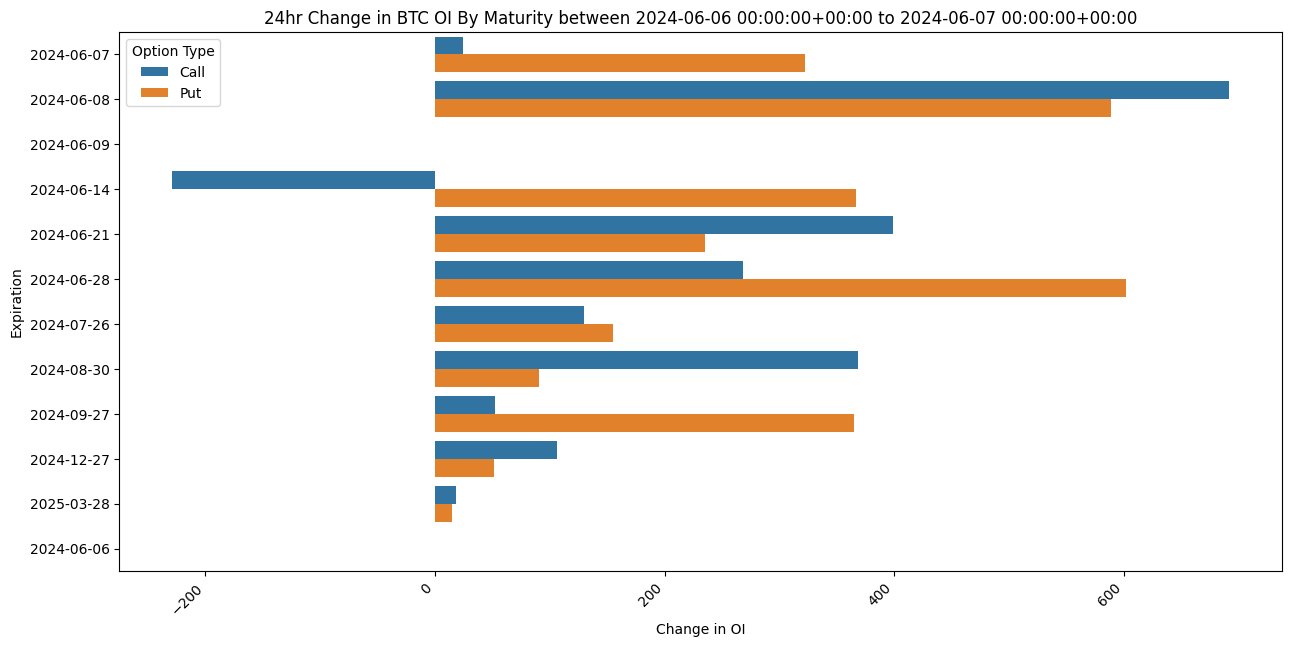

In [7]:
data = pd.DataFrame(amberdata_client.get_volatility_level_1_quotes(exchange='deribit', currency='btc', startDate='2024-06-05', endDate='2024-06-08', timeInterval='day')['payload']['data'])                                                     
data['timestamp'] = pd.to_datetime(data.timestamp)

yday = data[data.timestamp == '2024-06-06 00:00:00+00:00']
tday = data[data.timestamp == '2024-06-07 00:00:00+00:00']

tday_c = tday[tday.putCall=='C'].groupby("expirationTimestamp")[['openInterest']].sum()
tday_p = tday[tday.putCall=='P'].groupby("expirationTimestamp")[['openInterest']].sum()

yday_c = yday[yday.putCall=='C'].groupby("expirationTimestamp")[['openInterest']].sum()
yday_p = yday[yday.putCall=='P'].groupby("expirationTimestamp")[['openInterest']].sum()

calls = pd.concat([tday_c, yday_c], axis=1)
calls.columns = ['today', 'yesterday']
calls['diffs'] = calls.today - calls.yesterday

puts = pd.concat([tday_p, yday_p], axis=1)
puts.columns = ['today', 'yesterday']
puts['diffs'] = puts.today - puts.yesterday

calls['Option Type'] = 'Call'
puts ['Option Type'] = 'Put'

t = pd.concat([calls, puts], axis=0).reset_index()
t['expirationTimestamp'] = pd.to_datetime(t.expirationTimestamp).dt.date

plt.figure(figsize=(15, 7))
sns.barplot(data=t, x='diffs', y='expirationTimestamp', hue='Option Type', orient='h')

plt.xticks(rotation=45, ha='right');
plt.title("24hr Change in BTC OI By Maturity between " + str(yday.timestamp.iloc[0]) + " to " + str(tday.timestamp.iloc[0]))
plt.ylabel("Expiration")
plt.xlabel("Change in OI")
plt.legend(title='Option Type')